转化聚类结果

In [15]:
# import glob
# import re

# files = glob.glob("C:\\Users\\YihengSu\\Desktop\\STNWR\\net\\group\\OUTPUT.LOG*")
# for file in files:
#     with open(file,encoding='ANSI') as f:
#         data = f.read()
#         year = re.search(r"net(\d\d\d\d)", data).group(1)
#         matrix = re.search(r"Blocked Matrix\n(.*)Density Matrix", data, re.DOTALL).group(1).split("\n")[5:-5]
#         cl = [[], [], [], []]
#         with open(f"..\\net\\group\\id\\{year}.txt", 'w') as w:
#             n = 0
#             for c in matrix:
#                 l = c.split()
#                 if len(l) == 1:
#                     n += 1
#                 else:
#                     cl[n].append(int(l[0])-1)
#             print(year)
#             w.write(str(cl[0])[1:-1] + '\n')
#             w.write(str(cl[1])[1:-1] + '\n')
#             w.write(str(cl[2])[1:-1] + '\n')
#             w.write(str(cl[3])[1:-1] + '\n')
#         cl = [[], [], [], []]
#         with open(f".\\net\\group\\name\\{year}.txt", 'w') as w:
#             n = 0
#             for c in matrix:
#                 l = c.split()
#                 if len(l) == 1:
#                     n += 1
#                 else:
#                     cl[n].append(l[1])
#             print(year)
#             w.write(','.join(cl[0]) + '\n')
#             w.write(','.join(cl[1]) + '\n')
#             w.write(','.join(cl[2]) + '\n')
#             w.write(','.join(cl[3]) + '\n')

import pandas as pd
import glob

index = pd.read_csv('.\\data\\cityname.csv')
files = glob.glob(".\\net\\group\\*.xls")
for file in files:
    gr = pd.read_excel(file)
    df = pd.concat([gr, index], axis=1)
    grouped = df.groupby('2')
    idx = []
    name = []
    year = 2010 + int(file.split('\\')[-1][:-16])
    print(year)
    for n, group in grouped:
        name.append(group.values[:, 0])
        idx.append(group.values[:, 4])
    with open(f".\\net\\group\\id\\{year}.txt", 'w') as w:
        w.write(str(idx[0])[1:-1].replace('\n', '').replace(' ', ',') + '\n')
        w.write(str(idx[1])[1:-1].replace('\n', '').replace(' ', ',') + '\n')
        w.write(str(idx[2])[1:-1].replace('\n', '').replace(' ', ',') + '\n')
        w.write(str(idx[3])[1:-1].replace('\n', '').replace(' ', ',') + '\n')
    with open(f".\\net\\group\\name\\{year}.txt", 'w') as w:
        w.write(','.join(name[0]) + '\n')
        w.write(','.join(name[1]) + '\n')
        w.write(','.join(name[2]) + '\n')
        w.write(','.join(name[3]) + '\n')

2020
2011
2012
2013
2014
2015
2016
2017
2018
2019


In [16]:
# import numpy as np
num = 112
year_num = 10
year_begin = 2011
year_final = 2020
# m = np.zeros((num, num))
# for year in range(year_begin, year_final+1):
#     with open(f'..\\net\\group\\id\\{year}.txt') as f:
#         data = f.readlines()
#         for line in data:
#             l = line.strip('\n').split(',')
#             for i in l:
#                 for j in l:
#                     if j != i:
#                         m[int(i), int(j)] += 1
# np.savetxt('data\\Correction_factor.csv', m / 16, fmt='%.4f', delimiter=',')
# m / 16

In [18]:
import numpy as np

m = np.zeros((year_num, num, num))
for year in range(year_num):
    with open(f'.\\net\\group\\id\\{year_begin+year}.txt') as f:
        data = f.readlines()
        for line in data:
            l = line.strip('\n').split(',')
            for i in l:
                for j in l:
                    m[year, int(i), int(j)] += 1

In [19]:
m1 = np.tile(np.hstack(m), (year_num,1))
m2 = m1 + m1.T
np.savetxt('data\\Correction_factor_indi.csv', m2, fmt='%.1f', delimiter=',')

寻找最优参数

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mgtwr.sel_bw import Sel_BW
from mgtwr.model import Model
import pandas as pd
import multiprocessing as mp
import psutil

In [2]:
data = pd.read_csv('data\\面板数据.csv')
coords = data[['lon', 'lat', 'T']].values
X1 = data[['buildingHeight','constructionLand','urbanizationRate']].values
X2 = data[['degreeCentrality','closenessCentrality','betweennessCentrality']].values
X = np.hstack([X1, X2])
y = data[['carbonEmission']].values

w = np.loadtxt('data\\csj_网络距离矩阵_无聚类.csv', delimiter=',')
a= np.loadtxt('data\\Correction_factor_indi.csv', delimiter=',')

In [5]:
for i in range(50):
    c = 10 - 0.1 * i * a
    np.savetxt('data\\csj_网络距离矩阵.csv', w*c, fmt='%.4f', delimiter=',')
    
    del Sel_BW, Model
    from mgtwr.sel_bw import Sel_BW
    from mgtwr.model import Model
    
    try:
        with mp.Pool(psutil.cpu_count()) as pool:
            # sel = Sel_BW(coords, y, X, mode='gtwr', spherical=False, fixed=False)
            # bw, tau = sel.search(bw_max=120, tau_min=1., verbose=False, max_iter=100, pool=pool)
            gtwr = Model(coords, y, X, bw=55., tau=1., mode='gtwr', spherical=False, fixed=False)
            gtwr_results = gtwr.fit(pool=pool)
            print(i, gtwr_results.R2, gtwr_results.adj_R2)
    except:
        continue

0 0.9505781471641775 0.9301116876571617
1 0.9500721838242244 0.9295674007702245
2 0.9496660001935495 0.9291549221062897
3 0.9492149762854426 0.9287079268446367
4 0.948613279484105 0.9280375502966418
5 0.9480617489502762 0.927430525914046
6 0.9477825305783759 0.9271943070247752
7 0.9473805083177602 0.9268038794273114
8 0.9469472790216014 0.926428589124999
9 0.9461059847055591 0.9254629305403123
10 0.9451841088818245 0.9243952037593223
11 0.9444945671916336 0.9236940984610473
12 0.9433899033075346 0.9224190720698549
13 0.941996501711167 0.9208054608583329
14 0.9408340531953688 0.919488935750637
15 0.9394578670888619 0.9178727760334542
16 0.9380644587536215 0.9161919692603818
17 0.9369741977585436 0.9149330399968968
18 0.9360468243448199 0.9139117912554201
19 0.9347877528419256 0.9124400948146032
20 0.933532807601294 0.9109003908022758
21 0.9321557914092307 0.9092122549464157
22 0.9311322455638412 0.9079703156420671
23 0.9300097507692157 0.9066505112754004
24 0.9292591890163221 0.90585361

计算参与回归点

In [1]:
import pandas as pd
import numpy as np
from mgtwr_old.kernels import local_cdist

data = pd.read_csv('data\\面板数据.csv')
coords = data[['lon', 'lat', 'T']].values
coords

array([[ 118.767413,   32.041544, 2006.      ],
       [ 120.301663,   31.574729, 2006.      ],
       [ 117.184811,   34.261792, 2006.      ],
       ...,
       [ 117.489157,   30.656037, 2021.      ],
       [ 118.757995,   30.945667, 2021.      ],
       [ 121.472644,   31.231706, 2021.      ]])

In [2]:
coords[:, 2] *= np.sqrt(363931502)

out = []
for i in coords:
    out.append(local_cdist(i, coords, True))
out = np.array(out)
out[out <= 144599.86] = 1
out[out > 144599.86] = 0
out

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [3]:
res = []
for i in range(16):
    for j in range(16):
        res.append(out[41*i:41*(i+1), 41*j:41*(j+1)])
res = np.array(res)
print(res.shape)
c = np.sum(res, axis=0)
print(np.count_nonzero(c))
c

(256, 41, 41)
281


array([[184.,   0.,   0., ...,   0., 124.,   0.],
       [  0., 184.,   0., ...,   0.,   0., 124.],
       [  0.,   0., 184., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ..., 184., 100.,   0.],
       [124.,   0.,   0., ..., 100., 184.,   0.],
       [  0., 124.,   0., ...,   0.,   0., 184.]])

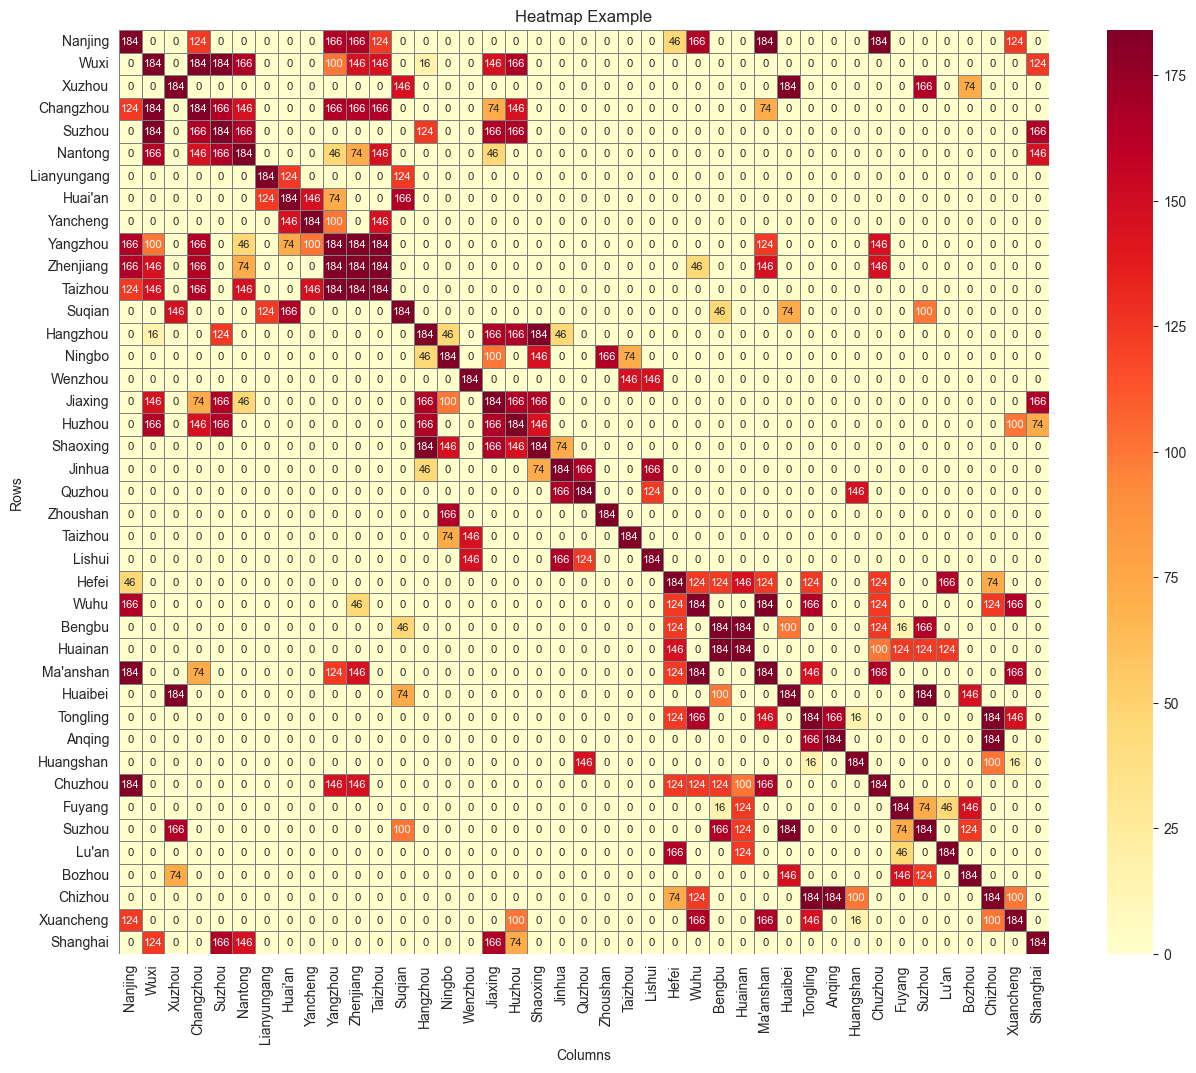

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

labels = ["Nanjing","Wuxi","Xuzhou","Changzhou","Suzhou","Nantong","Lianyungang","Huai'an","Yancheng","Yangzhou","Zhenjiang","Taizhou","Suqian","Hangzhou","Ningbo","Wenzhou","Jiaxing","Huzhou","Shaoxing","Jinhua","Quzhou","Zhoushan","Taizhou","Lishui","Hefei","Wuhu","Bengbu","Huainan","Ma'anshan","Huaibei","Tongling","Anqing","Huangshan","Chuzhou","Fuyang","Suzhou","Lu'an","Bozhou","Chizhou","Xuancheng","Shanghai"]
df = pd.DataFrame(c, index=labels, columns=labels)
df.to_csv('data\\csj_回归选择_地理距离矩阵.csv', index=True, header=True)

plt.figure(figsize=(15, 12))
sns.heatmap(df, annot=True, cmap='YlOrRd', linewidths=0.5, linecolor='grey', fmt=".0f", annot_kws={'size': 8}, vmax=184)

# 添加标题和标签
plt.title('Heatmap Example')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.savefig('地理距离.png', dpi=300)
# 显示图像
plt.show()
plt.close()

In [5]:
STA_W = np.loadtxt('data\\csj_网络距离矩阵.csv', delimiter=',')
STA_W[STA_W <= 89369.91] = 1
STA_W[STA_W > 89369.91] = 0
STA_W

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [6]:
res = []
for i in range(16):
    for j in range(16):
        res.append(STA_W[41*i:41*(i+1), 41*j:41*(j+1)])
res = np.array(res)
c = np.sum(res, axis=0)
print(np.count_nonzero(c))
c

417


array([[146.,   4.,   0., ...,   0.,   0.,   0.],
       [  0., 146.,   0., ...,   0.,   0.,   0.],
       [ 42.,  38., 146., ...,   0.,   0.,   7.],
       ...,
       [ 41.,  74.,   0., ..., 146.,   0.,   0.],
       [ 80., 100.,   0., ...,   0., 146.,   0.],
       [  0.,  15.,   0., ...,   0.,   0., 146.]])

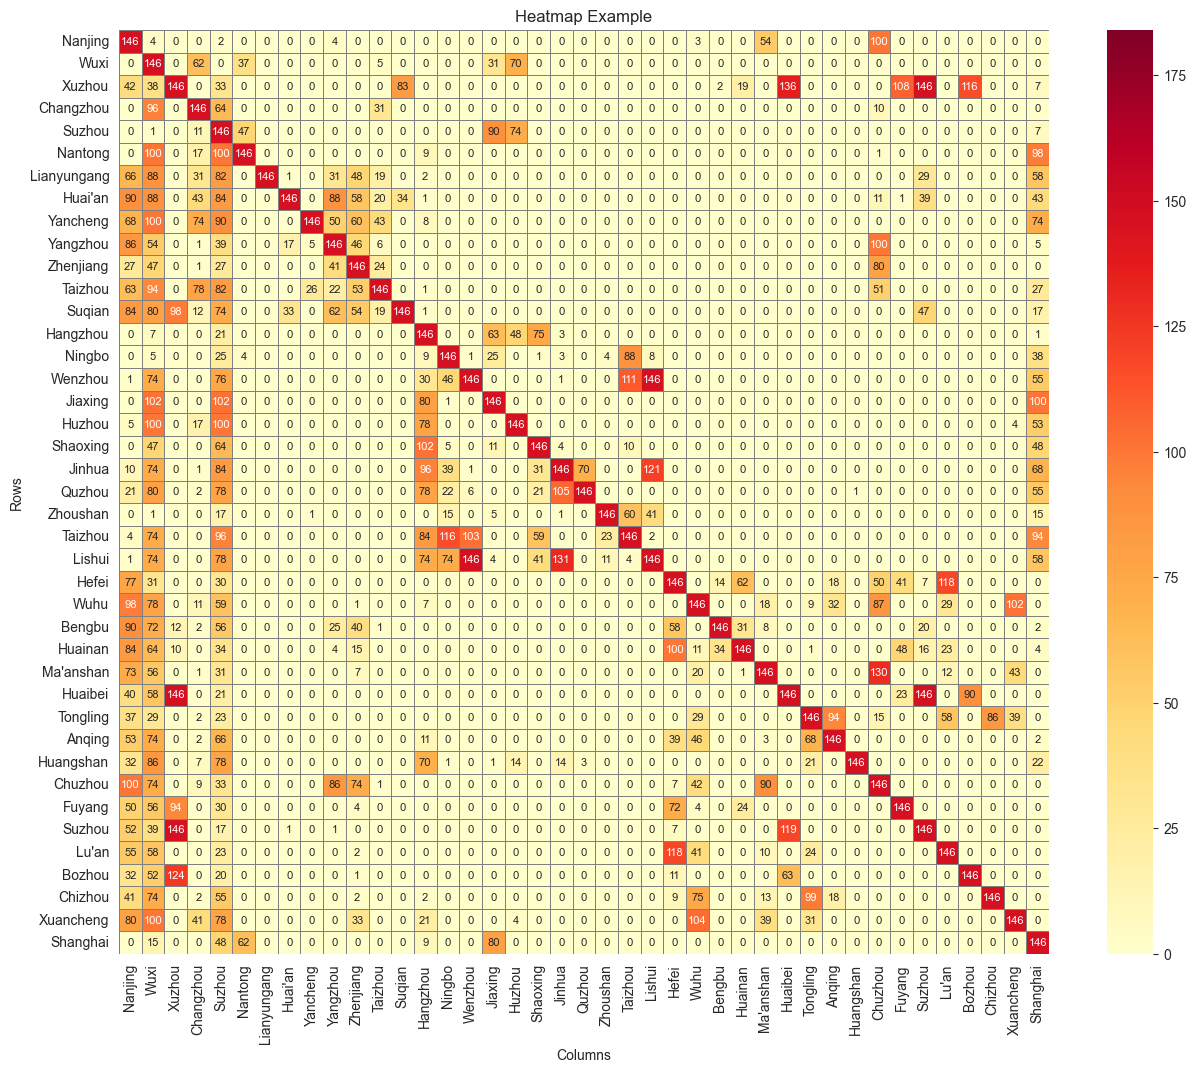

In [8]:
df1 = pd.DataFrame(c, index=labels, columns=labels)
df1.to_csv('data\\csj_回归选择_网络距离矩阵.csv', index=True, header=True)
plt.figure(figsize=(15, 12))
sns.heatmap(df1, annot=True, cmap='YlOrRd', linewidths=0.5, linecolor='grey', fmt=".0f", annot_kws={'size': 8}, vmax=184)

# 添加标题和标签
plt.title('Heatmap Example')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.savefig('网络距离.png', dpi=300)
# 显示图像
plt.show()
plt.close()

In [4]:
import numpy as np

with open('a.txt') as f:
    l = f.readlines()[0].replace(' ', '')
    li = eval(l)
np.array(li[-1][0])

array([[121.60864931,  28.47037537],
       [121.60850296,  28.47058852],
       [121.60850278,  28.47058872],
       ...,
       [121.60980085,  28.47118092],
       [121.60911105,  28.47053042],
       [121.60864931,  28.47037537]])

In [5]:
b = np.array(li[-1][0]).reshape(-1, 2, 2)[:, 0, :]

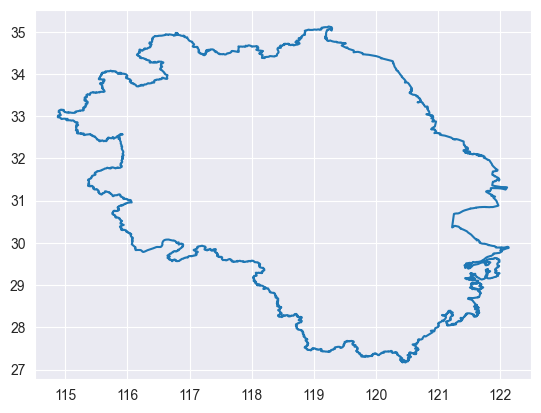

In [9]:
import matplotlib.pyplot as plt

plt.plot(b[:,0], b[:,1])

In [8]:
b.shape

(9644, 2)

In [6]:
import re

with open('s.txt', encoding='utf-8') as f:
    # ls = f.readlines()
    ll = f.read()
    print(ll)
    # print(len(ls))
    res = re.findall(r'https://.*?\n', ll)
    print(len(res))

[1] Huang L, Krigsvoll G, Johansen F, Liu Y, Zhang X. Carbon emission of global construction sector. Renewable and Sustainable Energy Reviews. 2018;81:1906-16. https://doi.org/10.1016/j.rser.2017.06.001.
[2] Huo T, Ma Y, Cai W, Liu B, Mu L. Will the urbanization process influence the peak of carbon emissions in the building sector? A dynamic scenario simulation. Energy and Buildings. 2021;232:110590. https://doi.org/10.1016/j.enbuild.2020.110590.
[3] Gao Y, Jonsson JC, Curcija DC, Vidanovic S, Hong T. Global and regional perspectives on optimizing thermo-responsive dynamic windows for energy-efficient buildings. Nature Communications. 2025;16:199. https://doi.org/10.1038/s41467-024-54967-8.
[4] Chen L, Huang L, Hua J, Chen Z, Wei L, Osman AI, et al. Green construction for low-carbon cities: a review. Environmental Chemistry Letters. 2023;21:1627-57. https://doi.org/10.1007/s10311-022-01544-4.
[5] Schleussner C-F, Ganti G, Lejeune Q, Zhu B, Pfleiderer P, Prütz R, et al. Overconfidence i

In [7]:
res

['https://doi.org/10.1016/j.rser.2017.06.001.\n',
 'https://doi.org/10.1016/j.enbuild.2020.110590.\n',
 'https://doi.org/10.1038/s41467-024-54967-8.\n',
 'https://doi.org/10.1007/s10311-022-01544-4.\n',
 'https://doi.org/10.1038/s41586-024-08020-9.\n',
 'https://doi.org/10.1038/d41586-025-00010-9.\n',
 'https://doi.org/10.1038/s41893-019-0462-4.\n',
 'https://doi.org/10.1038/s41560-018-0253-6.\n',
 'https://doi.org/10.1108/02630801211288198.\n',
 'https://doi.org/10.1038/s41597-024-02971-4.\n',
 'https://doi.org/10.1016/j.rser.2018.07.012.\n',
 'https://doi.org/10.1016/j.eng.2023.08.019.\n',
 'https://doi.org/10.1016/j.buildenv.2022.109730.\n',
 'https://doi.org/10.1016/j.jclepro.2015.08.078.\n',
 'https://doi.org/10.1016/j.apenergy.2022.120410.\n',
 'https://doi.org/10.1016/j.enbuild.2015.12.026.\n',
 'https://doi.org/10.1016/j.jclepro.2019.118793.\n',
 'https://doi.org/10.1016/j.eiar.2023.107346.\n',
 'https://doi.org/10.1016/j.buildenv.2015.09.011.\n',
 'https://doi.org/10.1016/j.en

In [9]:
res.sort()

In [10]:
res

['https://doi.org/10.1007/s10311-022-01544-4.\n',
 'https://doi.org/10.1007/s11442-020-1729-4.\n',
 'https://doi.org/10.1016/j.apenergy.2015.01.023.\n',
 'https://doi.org/10.1016/j.apenergy.2018.10.083.\n',
 'https://doi.org/10.1016/j.apenergy.2022.120410.\n',
 'https://doi.org/10.1016/j.apenergy.2023.122039.\n',
 'https://doi.org/10.1016/j.apenergy.2024.123689.\n',
 'https://doi.org/10.1016/j.apenergy.2024.125144.\n',
 'https://doi.org/10.1016/j.buildenv.2015.09.011.\n',
 'https://doi.org/10.1016/j.buildenv.2022.109730.\n',
 'https://doi.org/10.1016/j.buildenv.2024.112457.\n',
 'https://doi.org/10.1016/j.cities.2018.05.010.\n',
 'https://doi.org/10.1016/j.ecolind.2022.109333.\n',
 'https://doi.org/10.1016/j.eiar.2023.107346.\n',
 'https://doi.org/10.1016/j.enbuild.2015.12.026.\n',
 'https://doi.org/10.1016/j.enbuild.2020.110590.\n',
 'https://doi.org/10.1016/j.enbuild.2022.112136.\n',
 'https://doi.org/10.1016/j.eneco.2021.105269.\n',
 'https://doi.org/10.1016/j.energy.2022.126102.\n'